1. Descarga y Preparación de Datos


In [45]:
import pandas as pd
import numpy as np
import requests, zipfile, io
from tensorflow.keras.utils import to_categorical

# 1. Descarga limpia
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

def load_file(filepath):
    df = pd.read_csv(filepath, header=None, sep=r'\s+')
    return df.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)

# 3. Carga final
path = 'UCI HAR Dataset/'
filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
X_train = load_group(filenames, prefix=path + 'train/Inertial Signals/')
y_train = load_file(path + 'train/y_train.txt')

filenames_test = ['total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']
X_test = load_group(filenames_test, prefix=path + 'test/Inertial Signals/')
y_test = load_file(path + 'test/y_test.txt')

y_train = to_categorical(y_train - 1)
y_test = to_categorical(y_test - 1)

print("Datos listos")

Datos listos


2. Definición del Modelo CNN 1D

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

model = Sequential([
    # Capa 1: Convolución + Normalización
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    BatchNormalization(),

    # Capa 2: Menos filtros para evitar que memorice demasiado
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # Capa de "olvido" agresiva
    Dropout(0.6),

    Flatten(),

    # Capa densa con regularización L2 para simplificar el aprendizaje
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),

    Dense(n_outputs, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Modelo listo")

Modelo listo


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3. Entrenamiento

In [48]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
print("Entrenamiento completado")

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6072 - loss: 2.5303 - val_accuracy: 0.4119 - val_loss: 3.8684
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7890 - loss: 1.3502 - val_accuracy: 0.6590 - val_loss: 1.5266
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8471 - loss: 0.8965 - val_accuracy: 0.8246 - val_loss: 0.9698
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8762 - loss: 0.6720 - val_accuracy: 0.8073 - val_loss: 1.0514
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8975 - loss: 0.5525 - val_accuracy: 0.8147 - val_loss: 0.9461
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8938 - loss: 0.5190 - val_accuracy: 0.8219 - val_loss: 0.8522
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9074 - loss: 0.4703 - val_accuracy: 0.8429 - val_loss: 0.8195
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9057 - loss: 0.4454 - val_accu

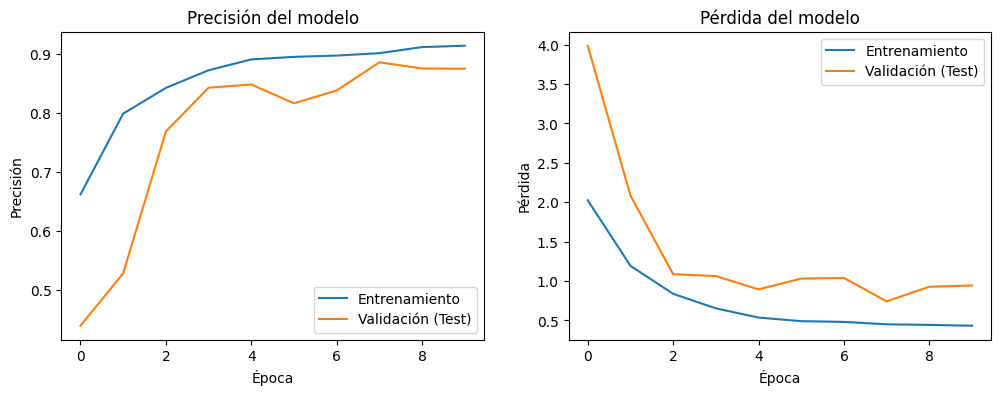

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Precisión (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación (Test)')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación (Test)')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


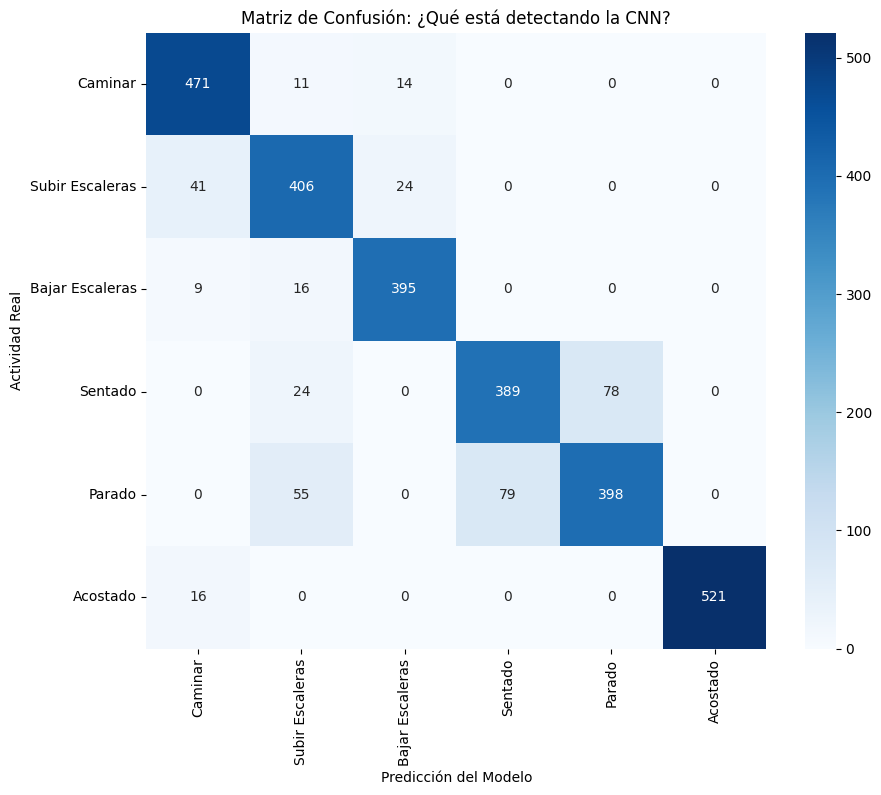

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Definir los nombres de las actividades (orden correcto del dataset)
activities = ['Caminar', 'Subir Escaleras', 'Bajar Escaleras', 'Sentado', 'Parado', 'Acostado']

# 2. Obtener las predicciones del modelo
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 3. Calcular la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4. Graficar usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=activities,
            yticklabels=activities)

plt.title('Matriz de Confusión: ¿Qué está detectando la CNN?')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Actividad Real')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


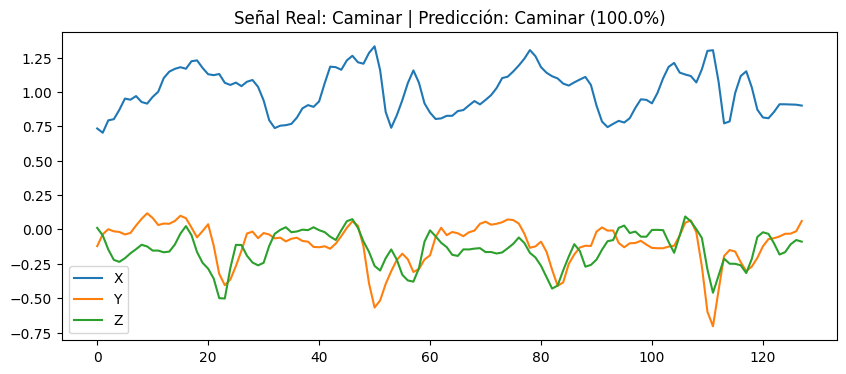

In [61]:
# Elegir un ejemplo al azar
idx = np.random.randint(0, len(X_test))
muestra = X_test[idx]
verdadera_actividad = activities[np.argmax(y_test[idx])]

# Predicción
prediccion = model.predict(muestra.reshape(1, 128, 3))
clase_predicha = activities[np.argmax(prediccion)]
confianza = np.max(prediccion) * 100

# Visualización de la señal
plt.figure(figsize=(10, 4))
plt.plot(muestra)
plt.title(f"Señal Real: {verdadera_actividad} | Predicción: {clase_predicha} ({confianza:.1f}%)")
plt.legend(['X', 'Y', 'Z'])
plt.show()

Pruebas sintéticas

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


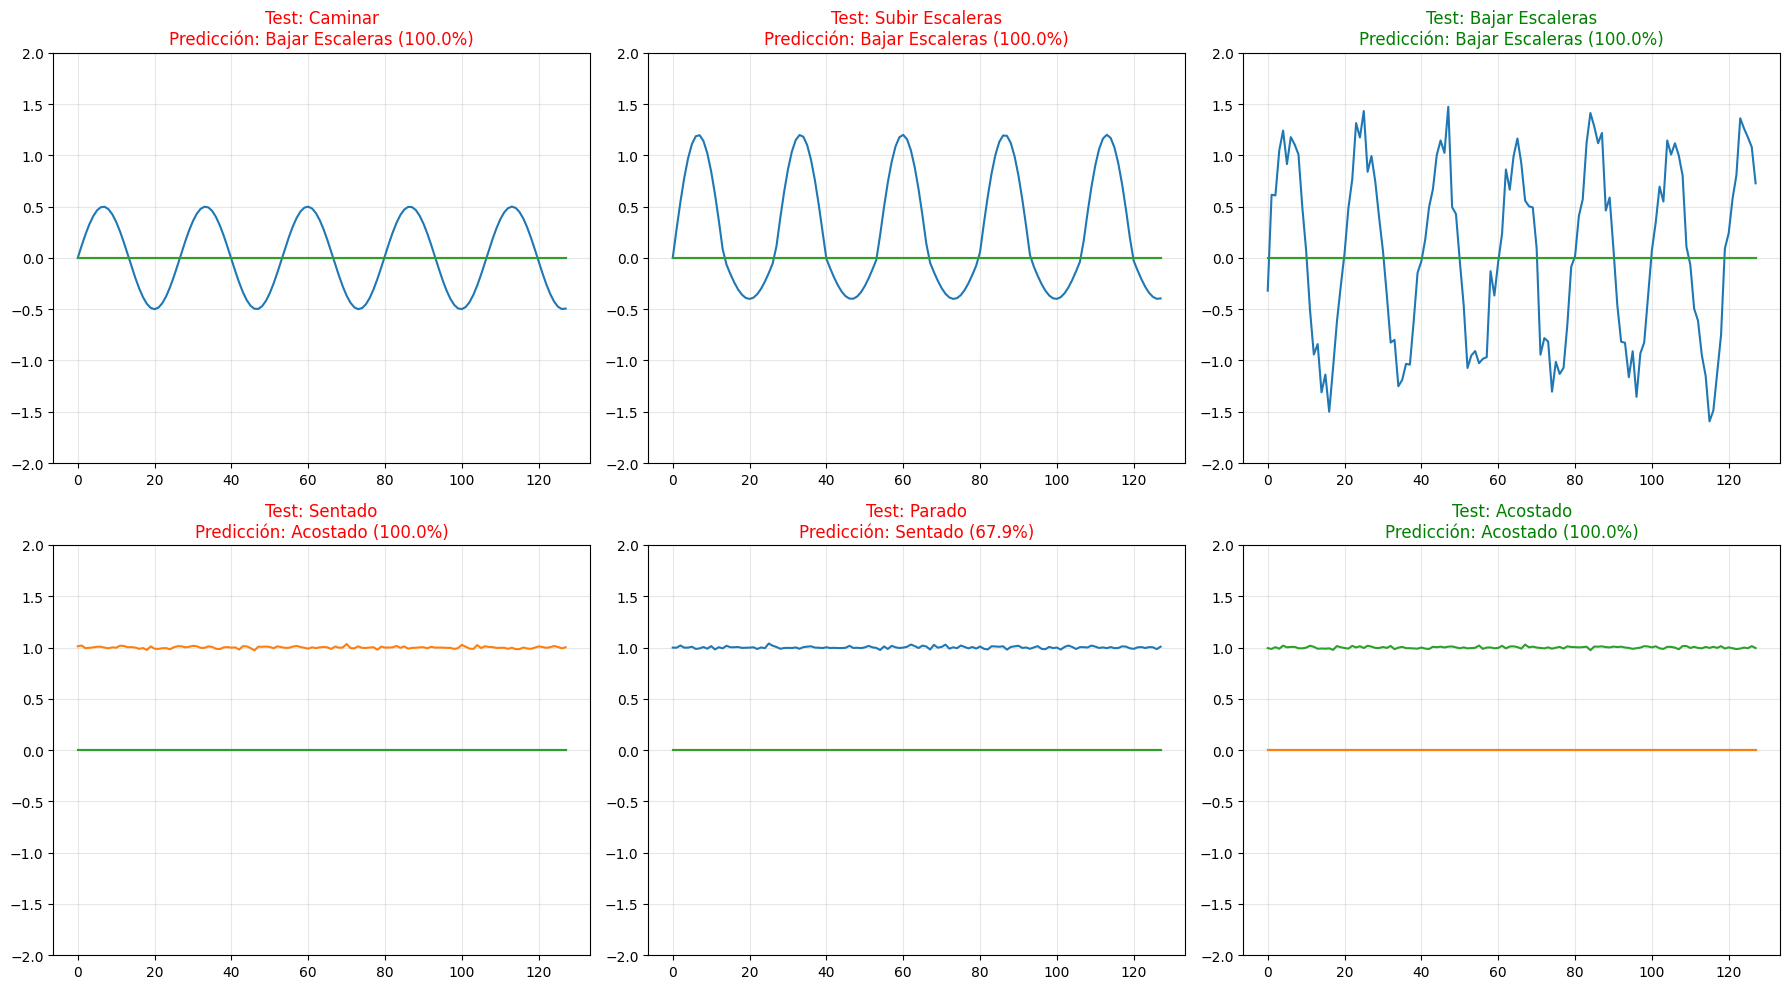

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def test_all_activities_synthetic(model):
    # Contenedor para 6 señales (una por actividad)
    # Forma: (6 muestras, 128 pasos de tiempo, 3 ejes)
    signals = np.zeros((6, 128, 3))
    t = np.linspace(0, 10, 128)

    # 1. CAMINAR: Ondas rítmicas constantes
    signals[0, :, 0] = np.sin(t * 3) * 0.5

    # 2. SUBIR ESCALERAS: Ondas rítmicas con picos de impacto más fuertes
    signals[1, :, 0] = np.sin(t * 3) * 0.8 + (np.abs(np.sin(t * 3)) * 0.4)

    # 3. BAJAR ESCALERAS: Impactos más bruscos y desordenados
    signals[2, :, 0] = np.sin(t * 4) * 1.2 + np.random.normal(0, 0.2, 128)

    # 4. SENTADO: Señal casi plana pero con un ángulo específico (Gravedad en eje Y)
    signals[3, :, 1] = 1.0 + np.random.normal(0, 0.01, 128)

    # 5. PARADO: Señal casi plana (Gravedad en eje X)
    signals[4, :, 0] = 1.0 + np.random.normal(0, 0.01, 128)

    # 6. ACOSTADO: Señal plana pero con la gravedad en un ángulo distinto (Eje Z)
    signals[5, :, 2] = 1.0 + np.random.normal(0, 0.01, 128)

    # Predicción
    predictions = model.predict(signals)
    activities = ['Caminar', 'Subir Escaleras', 'Bajar Escaleras', 'Sentado', 'Parado', 'Acostado']

    # Visualización en cuadrícula 2x3
    plt.figure(figsize=(18, 10))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.plot(signals[i])

        pred_idx = np.argmax(predictions[i])
        confianza = np.max(predictions[i]) * 100

        color = 'green' if pred_idx == i else 'red'
        plt.title(f"Test: {activities[i]}\nPredicción: {activities[pred_idx]} ({confianza:.1f}%)", color=color)
        plt.ylim(-2, 2)
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

test_all_activities_synthetic(model)